In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os as os
from sklearn.model_selection import train_test_split ####Only for splittinng the dataset, rest is in numpy

In [42]:
os.chdir('/home/aashish/assignment2')
##Change the directory on your system in order to run

In [43]:
##Read dataset from the directory given above
data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [44]:
train = data.drop(['label'], axis = 1)

In [45]:
label = data.label

In [46]:
##Convert the target values to one hot vectors
target = pd.get_dummies(label, columns=['label'], drop_first=False)

In [47]:
##Split data into training and cross val(testing)
x_train,x_cv,y_train,y_cv = train_test_split(train,target,test_size = 0.2, random_state = 42)

In [48]:
## Reshaping the dataframe to image
x_arr = np.array(x_train)
x_cv_arr = np.array(x_cv)
X = x_arr.reshape(33600,28,28,1)
X_cv = x_cv_arr.reshape(8400,28,28,1)

In [49]:
## PADDING function
def zero_pad(data, pad):
    data_pad = np.pad(data,((0,0),(pad,pad),(pad,pad),(0,0)), 'constant')
    
    return data_pad

In [50]:
##SoftMax cost calculation
def softmax_cost(out,y):
    eout = np.exp(out, dtype=np.float)  
    probs = eout/np.sum(eout, axis = 1)[:,None]
    
    p = np.sum(np.multiply(y,probs), axis = 1)
    prob_label = np.argmax(np.array(probs), axis = 1)    ## taking out the arguments of max values
    cost = -np.log(p)    ## (Only data loss. No regularised loss)
    
    return p,cost,probs,prob_label

In [51]:
##Convolution along with fully connected
def conv_net(input_data, Y, W1, b1, theta3,bias3):
    
    ####Forward propagation
    
    ## Input shape
    m, n_Hi, n_Wi, n_Ci = input_data.shape
    
    ## no. of filters in layer_1 
    l1 = len(W1)    ## All filters for conv layer 1 horizontally stacked in W1  
    
    (f, f, _) = W1[0].shape   ## Shape of the filter used
    pad = 1
    ## stride = 1
    
    ## Convolution layer1 output dimensions
    n_H1 = n_Hi+(2*pad)-f + 1
    n_W1 = n_Wi+(2*pad)-f + 1
   
    
    ## Initializing output image matrices after convolution
    conv1 = np.zeros((m,n_H1,n_W1,l1))
    
    ## Padding the input images
    input_pad = zero_pad(input_data,pad)
    
    ## First convolution layer
    for i in range(0,m):                                                  ##looping over the no. of examples
        for j in range(0,l1):                                             ##looping over the no. of filters
            for x in range(0,n_H1):                                       ##looping over the height of one image 
                for y in range(0,n_W1):                                   ##looping over the width of one image
                    conv1[i,x,y,j] = np.sum(input_pad[i,x:x+f,y:y+f]*W1[j])+b1[j]
        conv1[i,:,:,:][conv1[i,:,:,:] <= 0] = 0                           ##relu activation
        
    
    
    ## Fully connected layer of neurons
    fc1 = conv1.reshape(m,int((n_H1)*(n_W1)*l1))
    
    ## Output layer of mx10 activation units
    out = np.dot(fc1,theta3) + bias3
        
    ## Using softmax to get the cost    
    p, cost, probs, prob_label = softmax_cost(out, Y)   ## change it to y_train or batch
    
    ##Accuracy
    acc = []
    for i in range(0,len(Y)):
        if prob_label[i]==np.argmax(np.array(Y)[i,:]):
            acc.append(1)
        else:
            acc.append(0)

    ####### Backpropagation to compute gradients 
    
    d_out = probs - Y

    dtheta3 = np.dot(d_out.T, fc1)
    dbias3 = np.mean(d_out, axis = 0).reshape(1,10)    

    dfc1 = np.dot(theta3,d_out.T)
    
    dconv1 = dfc1.T.reshape((m, int(n_H1), int(n_W1), l1))

    
    dW1_stack = {}
    db1_stack = {}
    
    dW1_stack = np.zeros((m,l1,f,f,1))
    db1_stack = np.zeros((m,l1,1))

    bW1 = {}
    dW1 = np.zeros((l1,f,f,1))
    db1 = np.zeros((l1,1))
    
    
    for i in range(0,m):                          ## ## looping through the one batch of 32 examples
        for c in range(0,l1):
            for x in range(0,n_H1):
                for y in range(0,n_W1):
                    dW1_stack[i,:,:,c] += dconv1[i,x,y,c]*input_pad[i,x:x+f,y:y+f,:]

            db1_stack[i,c] = np.sum(dconv1[i,:,:,c])
            
        dW1 = np.mean(dW1_stack, axis = 0)
        db1 = np.mean(db1_stack, axis = 0)

        
        
    return dW1, db1, dtheta3, dbias3, cost, probs, prob_label, acc


In [52]:
#Function for optimizing the gradients
def optimizer(batch,learning_rate,W1,b1,theta3,bias3):
    
    ## Slicing train data and labels from batch
    X = batch[:,0:-10]
    X = X.reshape(len(batch), w, w, l)
    Y = batch[:,784:794]
    
    
    batch_size = len(batch)
    
    ## Initializing gradient matrices 
    bW1 = {}
    dW1 = np.zeros((l1,f,f,1))
    db1 = np.zeros((l1,1))
    
    dtheta3 = np.zeros(theta3.shape)
    dbias3 = np.zeros(bias3.shape)
    
    grads = conv_net(X,Y,W1,b1,theta3,bias3)
    [dW1, db1, dtheta3, dbias3, cost_, probs_, prob_label, acc_] = grads
    
    W1 = W1-learning_rate*(dW1)
    b1 = b1-learning_rate*(db1)
    theta3 = theta3-learning_rate*(dtheta3.T)
    bias3 = bias3-learning_rate*(dbias3)
    
    batch_cost = np.mean(cost_)
    batch_accuracy = sum(acc_)/len(acc_)
    
    return W1, b1, theta3, bias3, batch_cost, acc_, batch_accuracy

In [53]:
## Initializing weights and bias for convolution layer

W1 = 0.1*np.random.rand(3,3,3,1)

b1 = 0.1*np.random.rand(3,1)

## Initializing weights and bias for fully connected layer
theta3 = 0.1*np.random.rand(2352,10)

bias3 = 0.1*np.random.rand(1,10)

## Normalizing input data
x_arr -= int(np.mean(x_arr))
x_arr = x_arr.astype(float)
x_arr /= int(np.std(x_arr))

train_data = np.hstack((x_arr,np.array(y_train)))     ## horizontally stacking the features and labels 

## training the model on only 320 examples images due to heavy computation and training time issue.
t = train_data[0:320]      

## Normalizing cross-validation data
x_cv_arr -= int(np.mean(x_cv_arr))
x_cv_arr = x_cv_arr.astype(float)
x_cv_arr /= int(np.std(x_cv_arr))

cv_data = np.hstack((x_cv_arr,np.array(y_cv)))

## cross-validating the model on only 100 examples images due to heavy computation issue 
test_data = x_cv_arr[0:100]      

Y_cv = np.array(y_cv)[0:100]

np.random.shuffle(train_data)

## Assigning hyperparameter values
learning_rate = 0.001
batch_size = 32
num_epochs = 10
num_images = len(t)   ##Number of the input training examples
w = 28
l = 1
l1 = len(W1)    ## no. of filters in W1   
f = len(W1[0]) 

In [54]:
def main_init(train_data,W1,b1,theta3,bias3):
    cost = []
    accuracy = []
    for epoch in range(0, num_epochs):
        batches = [train_data[k:k + batch_size] for k in range(0, len(train_data), batch_size)]
        x=0
        i = 1
        for batch in batches:
            
            output = optimizer(batch,learning_rate,W1,b1,theta3,bias3)
            [W1, b1, theta3, bias3, batch_cost,acc_,batch_acc] = output
            
            
            cost.append(batch_cost)
            accuracy.append(batch_acc)

            print ('ep:%d, batch_num = %f, batch_cost = %f, batch_acc = %f' %(epoch,i,batch_cost,batch_acc)) 
            i+=1
    return W1,b1,theta3,bias3,cost,accuracy

ep:0, batch_num = 1.000000, batch_cost = 2.438226, batch_acc = 0.000000
ep:0, batch_num = 2.000000, batch_cost = 2.026648, batch_acc = 0.250000
ep:0, batch_num = 3.000000, batch_cost = 1.859162, batch_acc = 0.500000
ep:0, batch_num = 4.000000, batch_cost = 1.776929, batch_acc = 0.437500
ep:0, batch_num = 5.000000, batch_cost = 1.826753, batch_acc = 0.437500
ep:0, batch_num = 6.000000, batch_cost = 1.906376, batch_acc = 0.406250
ep:0, batch_num = 7.000000, batch_cost = 1.652833, batch_acc = 0.593750
ep:0, batch_num = 8.000000, batch_cost = 1.759697, batch_acc = 0.437500
ep:0, batch_num = 9.000000, batch_cost = 1.546569, batch_acc = 0.500000
ep:0, batch_num = 10.000000, batch_cost = 1.531392, batch_acc = 0.468750
ep:1, batch_num = 1.000000, batch_cost = 1.317698, batch_acc = 0.468750
ep:1, batch_num = 2.000000, batch_cost = 1.141754, batch_acc = 0.781250
ep:1, batch_num = 3.000000, batch_cost = 1.003990, batch_acc = 0.781250
ep:1, batch_num = 4.000000, batch_cost = 1.042406, batch_acc = 

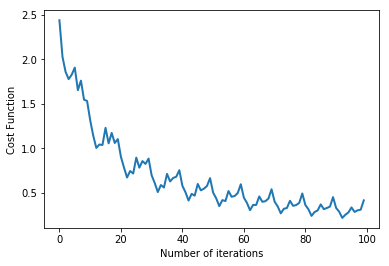

In [55]:
W1_t,b1_t,theta3_t,bias3_t,cost_t,accuracy_t = main_init(t,W1,b1,theta3,bias3)
plt.plot(cost_t, linewidth = 2)
plt.ylabel('Cost Function')
plt.xlabel('Number of iterations')
plt.show()

In [56]:
def predict(test_data, Y_cv, W1, b1, theta3, bias3, cost_t):
    
    ######## Forward Propagation 
    
    test_data = test_data.reshape(len(test_data),w,w,l)
    
    ## test shape
    m, n_Hi, n_Wi, n_Ci = test_data.shape
    
    ## no. of filters in layer_1 
    l1 = len(W1)    ## All filters for conv layer 1 horizontally stacked in W1  
    
    (f, f, _) = W1[0].shape   ## Shape of the filter used
    pad = 1
    ## stride = 1
    
    ## Convolution layer1 output dimensions
    n_H1 = n_Hi+(2*pad)-f + 1
    n_W1 = n_Wi+(2*pad)-f + 1
   
    ## Initializing output image matrices after convolution
    conv1 = np.zeros((m,n_H1,n_W1,l1))
    
    ## Padding the test images
    test_pad = zero_pad(test_data,pad)
    
    ## First convolution layer
    for i in range(0,m):                                                  ##looping over the no. of examples
        for j in range(0,l1):                                             ##looping over the no. of filters
            for x in range(0,n_H1):                                       ##looping over the height of one image 
                for y in range(0,n_W1):                                   ##looping over the width of one image
                    conv1[i,x,y,j] = np.sum(test_pad[i,x:x+f,y:y+f]*W1[j])+b1[j]
        conv1[i,:,:,:][conv1[i,:,:,:] <= 0] = 0                           ##relu activation
        
    
    ## Fully connected layer of neurons
    fc1 = conv1.reshape(m,int((n_H1)*(n_W1)*l1))
    
    ## Output layer of mx10 activation units
    out_t = np.dot(fc1,theta3) + bias3
        
    ## Using softmax to get the cost    
    p_pred, cost_pred, probs_pred, prob_label_pred = softmax_cost(out_t, Y_cv)  
    
    cv_acc = []
    for i in range(0,len(Y_cv)):
        if prob_label_pred[i]==np.argmax(np.array(Y_cv)[i,:]):
            cv_acc.append(1)
        else:
            cv_acc.append(0)
            
    cv_accuracy = sum(cv_acc)/len(cv_acc)
    print ('cv_acc = %f' %(cv_accuracy))
    
    
    return cost_pred, probs_pred, prob_label_pred

cv_acc = 0.800000


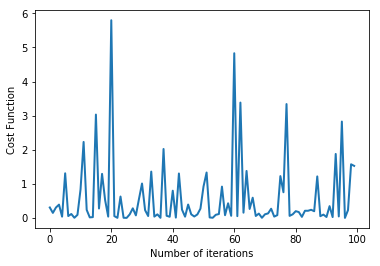

In [57]:
cost_pred_tst, probs_pred_tst, prob_label_pred_tst = predict(test_data, Y_cv, W1_t, b1_t, theta3_t, bias3_t, cost_t)
plt.plot(cost_pred_tst, linewidth = 2)
plt.ylabel('Cost Function')
plt.xlabel('Number of iterations')
plt.show()